# Mini project 

<p align="justify">
Build a machine learning model, which can identify and detect the following objects in a satellite image of a cyclone impacted area: 
<li>Undamaged Residential Building</li>
<li>Damaged Residential Building</li>
<li>Undamaged Commercial Building</li>
<li>Damaged Commercial Building</li>
</p>

## Load In Dependencies

In [10]:
### Run this cell only once.
# %pip install ultralytics
# !pip install opencv-python-headless
# !pip install labelme2yolo

In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# GeoTiff Images
import rasterio
from osgeo import gdal

# Visualisation
from matplotlib import pyplot as plt
import matplotlib.image as img
from matplotlib.pyplot import figure
from PIL import Image

# Model Building
import ultralytics
from ultralytics import YOLO
import labelme2yolo

# Others
import os
import shutil
import zipfile

## Importing the Data

In [1]:
pre_event_image = './Pre_Event_San_Juan.tif'
post_event_image ='./Post_Event_San_Juan.tif'

## Visualising GeoTiFF Images

In [4]:
# Open the geotiff file
def load_and_visualize(image_path):
    with rasterio.open(image_path) as src:
        # read the red, green and blue bands
        red = src.read(1)
        green = src.read(2)
        blue = src.read(3)
    # Plot the bands
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    ax1.imshow(red,cmap='Reds')
    ax1.set_title('Red Band')
    ax2.imshow(green, cmap='Greens')
    ax2.set_title('Green Band')
    ax3.imshow(blue, cmap='Blues')
    ax3.set_title('Blue Band')
plt.show()

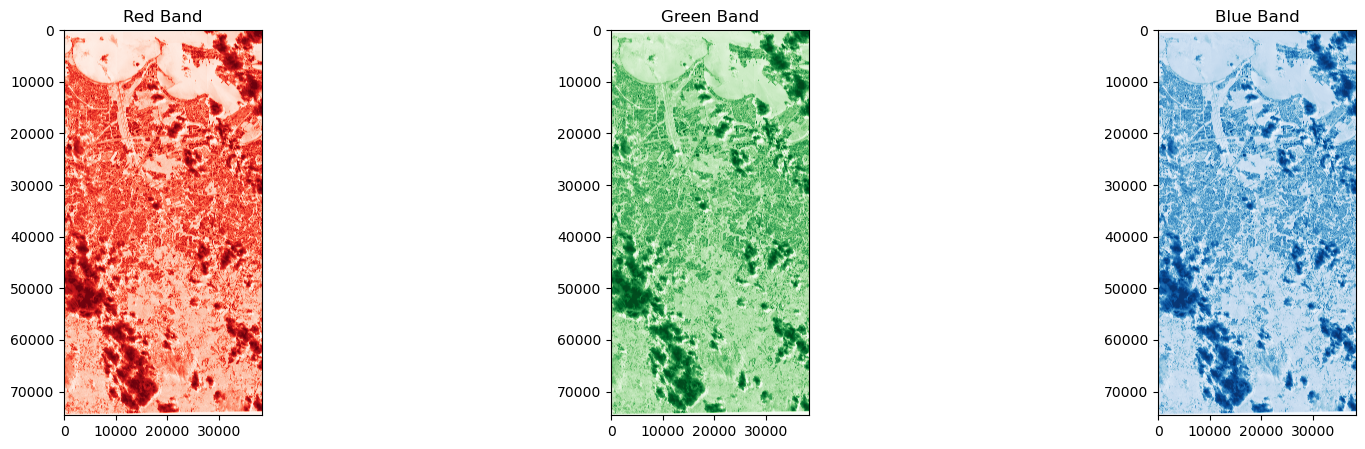

In [5]:
load_and_visualize(pre_event_image)

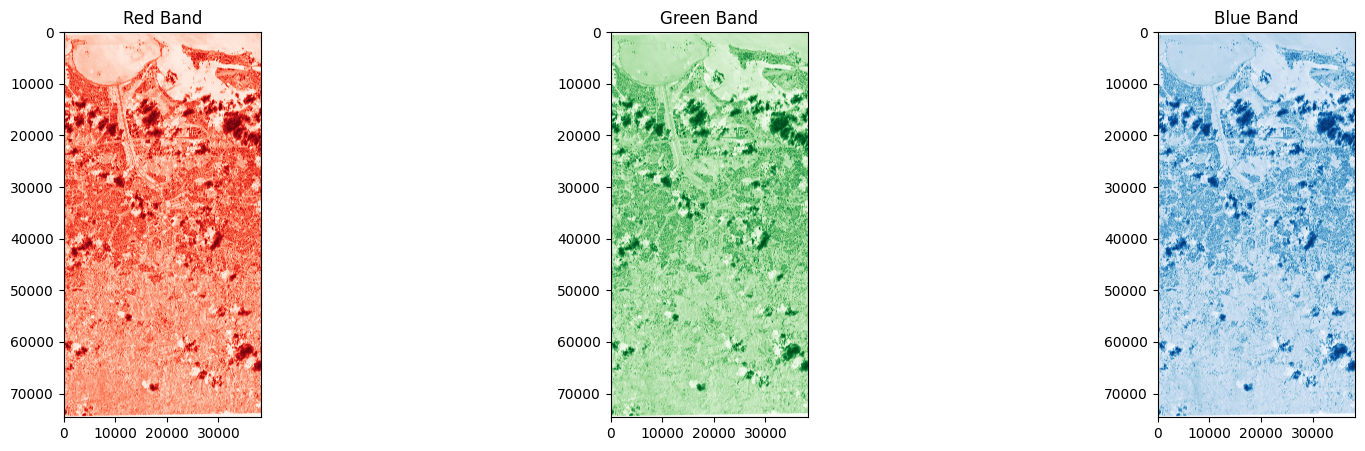

In [22]:
load_and_visualize(post_event_image)

## Data Pre Processing 

In [7]:
def generate_tiles(input_file, output_dir,grid_x,grid_y):
    ds = gdal.Open(input_file)

    # Get image size and number of bands
    width = ds.RasterXSize
    height = ds.RasterYSize
    num_bands = ds.RasterCount

    # Calculate number of tiles in each dimension
    num_tiles_x = (width // grid_x)
    num_tiles_y = (height // grid_y)

    print(f"Total number of tiles: {num_tiles_x * num_tiles_y}")

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over each tile and save as a separate TIFF image
    for i in range(num_tiles_x):
        for j in range(num_tiles_y):
            x_offset = i *  grid_x
            y_offset = j *  grid_y

            tile_width = min(grid_x, width - x_offset)
            tile_height = min(grid_y, height - y_offset)

            tile = []
            for band in range(1, num_bands + 1):
                tile_data = ds.GetRasterBand(band).ReadAsArray(x_offset, y_offset, tile_width, tile_height)
                tile.append(tile_data)

            # Create output filename
            output_file = os.path.join(output_dir, f"tile_{i}_{j}.tif")
                
            # Create an output TIFF file with same CRS and band values range
            driver = gdal.GetDriverByName("GTiff")
            options = ['COMPRESS=DEFLATE', 'PREDICTOR=2', 'TILED=YES']
            out_ds = driver.Create(output_file, tile_width, tile_height, num_bands, 
                       ds.GetRasterBand(1).DataType, options=options)
            # out_ds = driver.Create(output_file, tile_width, tile_height, num_bands, ds.GetRasterBand(1).DataType)

            # Set the geotransform
            geotransform = list(ds.GetGeoTransform())
            geotransform[0] = geotransform[0] + x_offset * geotransform[1]
            geotransform[3] = geotransform[3] + y_offset * geotransform[5]
            out_ds.SetGeoTransform(tuple(geotransform))

            # Set the projection
            out_ds.SetProjection(ds.GetProjection())

            # Write each band to the output file
            for band in range(1, num_bands + 1):
                out_band = out_ds.GetRasterBand(band)
                out_band.WriteArray(tile[band - 1])

            # Close the output file
            out_ds = None

    print("Tiles generation completed.")

In [8]:
input_file = "./Post_Event_San_Juan.tif"
output_dir = "./Post_Event_Grids_In_TIFF"
grid_x = 512
grid_y = 512
generate_tiles(input_file, output_dir,grid_x,grid_y)

Total number of tiles: 10730
Tiles generation completed.


## Annotating the Images

### Identifying Damaged and Undamged Infrastructure

### Converting Images to .png/.jpg images

In [1]:
def convert_tiff_to_jpeg(input_dir,output_dir):
    # check if output_dir exists, if not create it
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        # check if file is an image (ends with .tif)
        if filename.endswith('.tif'):
            img = Image.open(os.path.join(input_dir, filename))
        
            # check if image is RGB mode, if not convert it
            if img.mode != 'RGB':
                img = img.convert('RGB')
        
            # create new filename, replace .tif with .jpg
            output_filename = os.path.splitext(filename)[0] + '.jpg'
        
            # save the image in JPEG format
            img.save(os.path.join(output_dir, output_filename), 'JPEG')
    print("Conversion from TIFF to JPEG completed.")

In [8]:
# specify directory
input_dir = "./Post_Event_Grids_In_TIFF"
output_dir = "./Post_Event_Grids_In_JPEG"
convert_tiff_to_jpeg(input_dir,output_dir)

Conversion from TIFF to JPEG completed.


### Renaming the Files

In [9]:
def rename_files(directory_path):
# Define the directory path where your files are located
    directory_path = directory_path
    
    # Get a list of all files in the directory
    files = os.listdir(directory_path)
    
    # Define a prefix for the new file names 
    # Change the prefix as per requirement
    prefix = "Post_Event_"
    
    # Start the numbering from 1
    number = 0
    
    # Loop through each file in the directory
    for filename in files:
        # Check if the item is a file (not a directory)
        if os.path.isfile(os.path.join(directory_path, filename)):
            # Get the file extension
            file_extension = os.path.splitext(filename)[1]
    
            # Create the new file name with leading zeros
            new_filename = f"{prefix}{number:03}{file_extension}"
    
            # Construct the full path to the original and new files
            old_filepath = os.path.join(directory_path, filename)
            new_filepath = os.path.join(directory_path, new_filename)
    
            # Rename the file
            os.rename(old_filepath, new_filepath)
    
            # Increment the number for the next file
            number += 1
    
    print("Files renamed successfully.")

In [10]:
rename_files(output_dir)

Files renamed successfully.


In [13]:
import labelme2yolo
# !labelme2yolo --json_dir /path/to/labelme_json_dir/
python -m labelme2yolo --json_dir ./Annotated_Data

### Model Training

In [2]:
import ultralytics
from ultralytics import YOLO

In [3]:
#Loading the model
model = YOLO('yolov8n.pt')
# Display model information (optional)
model.info()

YOLOv8n summary: 225 layers, 3157200 parameters, 0 gradients


(225, 3157200, 0, 0.0)

In [ ]:
# Train the model on the dataset for 50 epochs
results = model.train(data='./data.yaml', epochs=50, imgsz=512)

Training completed and results saved to runs/detect/weights...